# Implement Kalman model using FastAI

> need to implement custom data preparation pipeline and loss function 

## Data Preparation

The aim of the data preparation pipeline is to:
- take the original time series and split it into time blocks
- for each block generate a random gap (need to figure out the properties of the gap)
- split some time blocks for testing

the input of the pipeline is:
- a dataframe containing all observations

the input of the model is:
- observed data (potentially containing NaN where data is missing)
- missing data mask (which is telling where the data is missing)
- the data needs to be standardized

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.fastai

In [ ]:
from meteo_imp.utils import *

In [ ]:
reset_seed()

In [ ]:
import torch

In [ ]:
from fastai.tabular.core import *
from fastai.data.core import *

In [ ]:
from fastcore.transform import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.all import *

In [ ]:
from fastai.tabular import *

In [ ]:
from meteo_imp.data import read_fluxnet_csv, hai_path

In [ ]:
from collections import namedtuple

In [ ]:
hai = read_fluxnet_csv(hai_path, None)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MaskedTensor(fastuple):
    pass

In [ ]:
class TimeSTensor(fastuple):
    """Multivariate TimeSeries PyTorch Tensor"""
    pass

In [ ]:
class MeteoImpTransform(ItemTransform):
    def __init__(self, df, block_len=200): 
        self.block_len = block_len
        n = len(df)
        for i in range(0, n, block_len):
            end = i+block_len
            end = end if end < n else n
            time_block = torch.tensor(df[i:i+block_len].to_numpy())
            self.blocks.append(time_block) # does this copy memory?
        
    def encodes(self, i) -> MaskedTensor:
        
        block = self.blocks[i]
        
        start = i * self.block_len
        end = i+block_len
        end = end if end < n else n
        
        return MaskedTensor(block)
    


the first step is to transfrom the original dataframe into blocks of a specified `block_len`

two different strategies are possible:

- contigous blocks
- random block in the dataframe

In [ ]:
class BlockDfTransform(ItemTransform):
    """divide timeseries DataFrame into blocks"""
    def __init__(self, df, block_len=200): 
        self.df = df 
        self.block_len = block_len
        self.n = len(df)
        
    def encodes(self, i:int) -> pd.DataFrame:       
        start = i * self.block_len
        end = (i+1) * self.block_len
        assert end <= self.n 
        
        block = self.df[start:end]
        
        return block

In [ ]:
m = BlockDfTransform(hai[:100], 10)

In [ ]:
m

BlockDfTransform:
encodes: (int,object) -> encodes
decodes: 

In [ ]:
m(1)

,TA,SW_IN,VPD
TIMESTAMP_END,,,
200001011712.0,-0.23,0.00,0.138
200001011712.0,-0.23,0.00,0.122
200001011712.0,-0.22,0.00,0.098
200001011712.0,-0.24,0.00,0.066
200001011712.0,-0.23,0.00,0.044
200001011712.0,-0.22,0.00,0.026
200001011712.0,-0.19,0.45,0.016
200001011712.0,-0.14,3.70,0.010
200001011712.0,-0.03,7.26,0.006


In [ ]:
m(9)

,TA,SW_IN,VPD
TIMESTAMP_END,,,
200001028096.0,0.97,0.0,0.192
200001028096.0,0.85,0.0,0.149
200001028096.0,0.77,0.0,0.112
200001028096.0,0.63,0.0,0.075
200001028096.0,0.52,0.0,0.038
200001028096.0,0.48,0.0,0.021
200001028096.0,0.41,0.0,0.013
200001028096.0,0.29,0.0,0.004
200001028096.0,0.31,0.0,0.000


In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: int = None # Optional start of gap
): # (total_length) array of bools to indicicate if the data is missing or not
    "Add a continous gap of ginve length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    gap_start = np.random.randint(total_length - gap_length) if gap_start is None else gap_start
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
from fastcore.basics import *

In [ ]:
MaskedDf = namedtuple('MaskedDf', 'data mask')

In [ ]:
@patch
def show(self: MaskedDf, ax=None, ctx=None, **kwargs):
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots()
    self.data.plot(ax=ax)

In [ ]:
class AddGapTransform(ItemTransform):
    """Adds a random gap to a `TimeSTensor`"""
    def __init__(self,
                variables,
                gap_length,
                ):
        store_attr()
    def encodes(self, df: pd.DataFrame):
        gap = _make_random_gap(self.gap_length, df.shape[0])
        mask = np.ones_like(df, dtype=bool)
        col_sel = L(*df.columns).argwhere(lambda x: x in self.variables)
        mask[np.argwhere(gap), col_sel] = False
        return MaskedDf(df, pd.DataFrame(mask))

In [ ]:
a_gap = AddGapTransform(['TA', 'VPD'], 5)
a_gap

AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: 

In [ ]:
a_gap(m(1))

MaskedDf(data=                  TA  SW_IN    VPD
TIMESTAMP_END                     
200001011712.0 -0.23   0.00  0.138
200001011712.0 -0.23   0.00  0.122
200001011712.0 -0.22   0.00  0.098
200001011712.0 -0.24   0.00  0.066
200001011712.0 -0.23   0.00  0.044
200001011712.0 -0.22   0.00  0.026
200001011712.0 -0.19   0.45  0.016
200001011712.0 -0.14   3.70  0.010
200001011712.0 -0.03   7.26  0.006
200001011712.0  0.04  12.24  0.006, mask=       0     1      2
0   True  True   True
1   True  True   True
2   True  True   True
3  False  True  False
4  False  True  False
5  False  True  False
6  False  True  False
7  False  True  False
8   True  True   True
9   True  True   True)

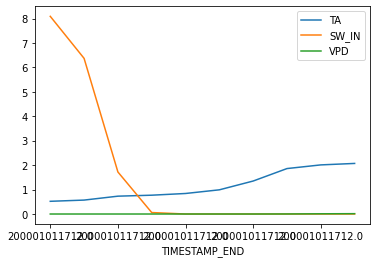

In [ ]:
a_gap(m(3)).show()

In [ ]:
idx = L(*m(1).columns).argwhere(lambda x: x in ['TA','SW_IN'])

In [ ]:
mask = np.ones_like(m(1), dtype=bool)

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
gap = _make_random_gap(2, 10, 2)

In [ ]:
gap

array([False, False,  True,  True, False, False, False, False, False,
       False])

In [ ]:
np.argwhere(gap)

array([[2],
       [3]])

In [ ]:
mask[np.argwhere(gap), idx] = False

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True],
       [False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
mask[gap]

array([[False, False,  True],
       [False, False,  True]])

In [ ]:
# MaskedTensor = namedtuple('MaskedTensor', 'data mask')

class MaskedTensor(fastuple):
    pass

In [ ]:
class MaskedDf2Tensor(ItemTransform):
    def setups(self, items):
        self.columns = list(items[0].data.columns)
    def encodes(self, df: MaskedDf) -> MaskedTensor:
        data = torch.tensor(df[0].to_numpy())
        mask = torch.tensor(df[1].to_numpy())
        return MaskedTensor(data, mask)
        
    def decodes(self, x: MaskedTensor) -> MaskedDf:
        data = pd.DataFrame(x[0].detach().cpu().numpy(), columns = self.columns)
        mask = x[1].numpy()
        return MaskedDf(mask, data)

In [ ]:
tfms = TfmdLists([1,2,3], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor ])

In [ ]:
tfms[1]

(tensor([[1.0000e-01, 1.6510e+01, 6.0000e-03],
         [1.8000e-01, 2.4730e+01, 1.1000e-02],
         [2.1000e-01, 4.7420e+01, 1.9000e-02],
         [2.3000e-01, 2.2050e+01, 1.4000e-02],
         [3.3000e-01, 1.8860e+01, 8.0000e-03],
         [4.1000e-01, 2.1100e+01, 6.0000e-03],
         [4.4000e-01, 2.8870e+01, 0.0000e+00],
         [4.8000e-01, 2.4220e+01, 0.0000e+00],
         [4.9000e-01, 2.4350e+01, 0.0000e+00],
         [5.1000e-01, 1.5680e+01, 0.0000e+00]]),
 tensor([[False, False,  True],
         [False, False,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]))

In [ ]:
type(tfms[0])

__main__.MaskedTensor

In [ ]:
from meteo_imp.utils import *

In [ ]:
from torch import Tensor

In [ ]:
def get_stats(df):
    return torch.tensor(df.mean(axis=0).to_numpy()), torch.tensor(df.std(axis=0).to_numpy())

In [ ]:
class NormalizeMasked(ItemTransform):
    "Normalize/denorm MaskedTensor column-wise "
    parameters,order = L('mean', 'std'),99
    def __init__(self, mean=None, std=None, axes=(0,)): store_attr()

    def encodes(self, x:MaskedTensor):
        return MaskedTensor((x[0]-self.mean) / self.std, x[1])

    def encodes(self, x):
        return MaskedTensor((x[0]-self.mean) / self.std, x[1])
    
    def decodes(self, x:ListNormal):
        mean = (x.std-self.mean) / self.std
        std = x.cov * self.std
        
        return ListNormal(mean, std)

In [ ]:
b = TfmdLists([0,1], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor, NormalizeMasked(*get_stats(hai))]).dataloaders(bs=2).one_batch()[0]

In [ ]:
b[0].mean(0)

tensor([-1.0730, -0.5813, -0.7617])

In [ ]:
b[1].mean(0)

tensor([-1.1083, -0.5929, -0.7457])

In [ ]:
b.std(axis=(0,1))

tensor([0.0232, 0.0154, 0.0128])

### Split training / validation

In [ ]:
block_len = 10
block_ids = list(range(0, (len(hai) // block_len) - 1))[:10]
gap_len = 2

In [ ]:
from fastai.data.transforms import *

In [ ]:
pipeline = [BlockDfTransform(hai, block_len), AddGapTransform(['TA','SW_IN'], gap_len), MaskedDf2Tensor, NormalizeMasked(*get_stats(hai))]

In [ ]:
splits = RandomSplitter()(block_ids)

In [ ]:
tls = TfmdLists(block_ids, pipeline, splits=splits)

In [ ]:
tls

TfmdLists: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tfms - [BlockDfTransform:
encodes: (int,object) -> encodes
decodes: , AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: , MaskedDf2Tensor:
encodes: (MaskedDf,object) -> encodes
decodes: (MaskedTensor,object) -> decodes
, NormalizeMasked:
encodes: (MaskedTensor,object) -> encodes
(object,object) -> encodes
decodes: (ListNormal,object) -> decodes
]

In [ ]:
type(tls[0])

__main__.MaskedTensor

In [ ]:
tls[0][0].shape, tls[0][1].shape

(torch.Size([10, 3]), torch.Size([10, 3]))

In [ ]:
dls = tls.dataloaders(bs=1)

In [ ]:
dls.one_batch()

(tensor([[[-1.1274, -0.5929, -0.7231],
          [-1.1337, -0.5929, -0.7460],
          [-1.1248, -0.5929, -0.7533],
          [-1.1160, -0.5929, -0.7487],
          [-1.1135, -0.5929, -0.7505],
          [-1.1021, -0.5929, -0.7485],
          [-1.0971, -0.5929, -0.7489],
          [-1.0958, -0.5929, -0.7494],
          [-1.0870, -0.5929, -0.7460],
          [-1.0857, -0.5929, -0.7423]]]),
 tensor([[[ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True],
          [False, False,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]]]))

In [ ]:
next(iter(dls.train))

(tensor([[[-0.9721,  0.2772, -0.7032],
          [-0.9595,  0.1329, -0.6947],
          [-0.9532,  0.0069, -0.7059],
          [-0.9192,  0.0454, -0.6940],
          [-0.9015,  0.0185, -0.6910],
          [-0.8737, -0.0505, -0.6867],
          [-0.8573, -0.3095, -0.6894],
          [-0.9154, -0.4367, -0.7189],
          [-0.9734, -0.4954, -0.7485],
          [-0.9797, -0.5498, -0.7597]]]),
 tensor([[[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True],
          [False, False,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]]]))

In [ ]:
type(dls.one_batch())

__main__.MaskedTensor

In [ ]:
ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=1)

In [ ]:
dls.one_batch()

((tensor([[[-1.1274, -0.5929, -0.7231],
           [-1.1337, -0.5929, -0.7460],
           [-1.1248, -0.5929, -0.7533],
           [-1.1160, -0.5929, -0.7487],
           [-1.1135, -0.5929, -0.7505],
           [-1.1021, -0.5929, -0.7485],
           [-1.0971, -0.5929, -0.7489],
           [-1.0958, -0.5929, -0.7494],
           [-1.0870, -0.5929, -0.7460],
           [-1.0857, -0.5929, -0.7423]]]),
  tensor([[[ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [False, False,  True],
           [False, False,  True],
           [ True,  True,  True]]])),
 (tensor([[[-1.1274, -0.5929, -0.7231],
           [-1.1337, -0.5929, -0.7460],
           [-1.1248, -0.5929, -0.7533],
           [-1.1160, -0.5929, -0.7487],
           [-1.1135, -0.5929, -0.7505],
           [-1.1021, -0.5929, -0.7485],
           [-

## Model

### Forward

in order to the a pytorch module we need a forward method to the kalman filter

In [ ]:
from meteo_imp.kalman.filter import *
from torch.distributions import MultivariateNormal

In [ ]:
class ListNormal(fastuple):
    pass

In [ ]:
@patch
def forward(self: KalmanFilter, data: MaskedTensor):
    data, mask = data
    assert data.shape[0] == 1
    data = data.squeeze(0)
    filter_mask = mask.squeeze(0).all(1)
    times = torch.arange(data.shape[0])
    mean, cov = self.predict(data, mask=filter_mask, times=times)
    return ListNormal(mean, cov)

In [ ]:
model = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

In [ ]:
input = dls.one_batch()[0]
target = dls.one_batch()[1]

In [ ]:
pred = model(input)

In [ ]:
def imp_ll_loss(pred: ListNormal, target: MaskedTensor):
    "Log Likelihood loss for imputation (with MaskedTensor)"
    data, mask = target
    data, mask = data.squeeze(), mask.squeeze()

    means, covs = pred
    
    
    times = torch.argwhere(~mask.all(1))
    
    lls = torch.zeros(len(times))
    for i, t in enumerate(times):
        
        lls[i] = MultivariateNormal(means[t], covs[t]).log_prob(data[t:t+1])
    return -lls.sum() 
    
    # print(out, target)

In [ ]:
MultivariateNormal(pred[0][0], pred[1][0]).log_prob(target[0][0:1])

tensor([[-3.3377, -3.3429, -3.3469, -3.3528, -3.3581, -3.3602, -3.3629, -3.3675,
         -3.3670, -3.3633]], grad_fn=<SubBackward0>)

In [ ]:
mask = input[1].squeeze()

In [ ]:
mask.shape

torch.Size([10, 3])

In [ ]:
mask

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

In [ ]:
mask.all(1)

tensor([ True,  True, False, False,  True,  True,  True,  True,  True,  True])

In [ ]:
imp_ll_loss(pred, target)

tensor(7.1972, grad_fn=<NegBackward0>)

In [ ]:
from fastai.learner import * 

In [ ]:
learn = Learner(dls, model, loss_func=imp_ll_loss)

In [ ]:
from fastai.tabular.all import *

In [ ]:
import fastai

In [ ]:
model0 = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

In [ ]:
model0.transition_cov_raw

Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True)

In [ ]:
learn.model(input)

(tensor([[-0.6299, -0.3042, -0.4706],
         [-0.8508, -0.4006, -0.6394],
         [-0.8935, -0.4260, -0.6762],
         [-0.9362, -0.4513, -0.7129],
         [-0.9789, -0.4766, -0.7497],
         [-0.9905, -0.4781, -0.7641],
         [-0.9926, -0.4682, -0.7702],
         [-0.9912, -0.4750, -0.7725],
         [-0.9899, -0.4826, -0.7733],
         [-0.9886, -0.4993, -0.7736]], grad_fn=<CopySlices>),
 tensor([[[1.3905, 0.0000, 0.0000],
          [0.0000, 1.3905, 0.0000],
          [0.0000, 0.0000, 1.3905]],
 
         [[1.5147, 0.0000, 0.0000],
          [0.0000, 1.5147, 0.0000],
          [0.0000, 0.0000, 1.5147]],
 
         [[1.9931, 0.0000, 0.0000],
          [0.0000, 1.9931, 0.0000],
          [0.0000, 0.0000, 1.9931]],
 
         [[1.9974, 0.0000, 0.0000],
          [0.0000, 1.9974, 0.0000],
          [0.0000, 0.0000, 1.9974]],
 
         [[1.5275, 0.0000, 0.0000],
          [0.0000, 1.5275, 0.0000],
          [0.0000, 0.0000, 1.5275]],
 
         [[1.4590, 0.0000, 0.0000],
     

In [ ]:
learn.fit(1, 1e-5)





































































































[0, 6.978353023529053, 6.638154983520508, '00:00']


In [ ]:
t_data = tensor([[-0.8195, -0.5929, -0.6876],
        [-0.8182, -0.5929, -0.6791],
        [-0.8510, -0.5929, -0.6924],
        [-0.8712, -0.5929, -0.7270],
        [-0.8838, -0.5929, -0.7309],
        [-0.8964, -0.5929, -0.7208],
        [-0.9204, -0.5929, -0.7121],
        [-0.9330, -0.5929, -0.7114],
        [-0.9494, -0.5929, -0.7224],
        [-0.9520, -0.5929, -0.7457]])

t_mask = tensor([ True,  True, False, False,  True,  True,  True,  True,  True,  True])

In [ ]:
torch.tensor([[ 2.6177e+00, -9.0837e-05, -9.0419e-05],
        [-8.8900e-05,  2.6176e+00, -8.8869e-05],
        [-8.9641e-05, -8.9868e-05,  2.6176e+00]])

tensor([[ 2.6177e+00, -9.0837e-05, -9.0419e-05],
        [-8.8900e-05,  2.6176e+00, -8.8869e-05],
        [-8.9641e-05, -8.9868e-05,  2.6176e+00]])

In [ ]:
curr_cov = torch.tensor([[ 1.6176e+00, -3.7789e-05, -3.7747e-05],
        [-3.7191e-05,  1.6176e+00, -3.7126e-05],
        [-3.7507e-05, -3.7434e-05,  1.6176e+00]])

In [ ]:
transition_cov = torch.tensor([[9.9996e-01, 6.9326e-06, 6.6949e-06],
        [6.9326e-06, 9.9996e-01, 7.0241e-06],
        [6.6949e-06, 7.0241e-06, 9.9996e-01]])

In [ ]:
trans_matrix = torch.tensor([[ 1.0000e+00, -1.8540e-05, -1.8350e-05],
        [-1.8126e-05,  1.0000e+00, -1.8165e-05],
        [-1.8184e-05, -1.8378e-05,  1.0000e+00]])

In [ ]:
trans_m = torch.tensor(
    [[ 1.3402, -0.3275, -0.3409],
    [-0.1406,  1.3446, -0.2451],
    [-0.2237, -0.3142,  1.3441]]
)

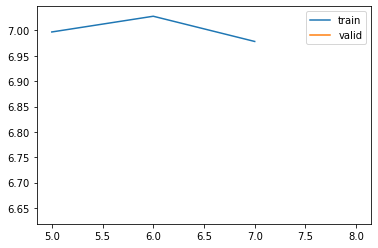

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.state_dict()

OrderedDict([('transition_matrices',
              tensor([[ 1.0001e+00, -5.1014e-05, -4.8273e-05],
                      [-4.8678e-05,  1.0001e+00, -4.8022e-05],
                      [-4.9636e-05, -5.4158e-05,  1.0001e+00]])),
             ('transition_offsets',
              tensor([4.3963e-05, 4.4164e-05, 4.4088e-05])),
             ('transition_cov_raw',
              tensor([[ 9.9992e-01, -1.3917e-05, -1.5459e-05],
                      [-1.3917e-05,  9.9992e-01, -1.3652e-05],
                      [-1.5459e-05, -1.3653e-05,  9.9992e-01]])),
             ('obs_matrices',
              tensor([[9.9992e-01, 5.0098e-05, 4.9092e-05],
                      [5.0098e-05, 9.9993e-01, 5.0390e-05],
                      [4.9092e-05, 5.0390e-05, 9.9992e-01]])),
             ('obs_offsets', tensor([5.5735e-05, 5.4989e-05, 5.7260e-05])),
             ('obs_cov_raw',
              tensor([[9.9992e-01, 1.5981e-05, 1.6149e-05],
                      [1.5981e-05, 9.9992e-01, 1.5871e-05],
        

In [ ]:
check_posdef(learn.obs_cov)
check_posdef(learn.transition_cov)
check_posdef(learn.initial_state_cov)

In [ ]:
pred_cov = torch.tensor([[ 0.5381, -0.2188, -0.2747],
        [-0.2188,  0.6433, -0.0257],
        [-0.2747, -0.0257,  0.5140]])

In [ ]:
check_posdef(pred_cov)

In [ ]:
learn.model(input)

(tensor([[-0.6301, -0.3043, -0.4708],
         [-0.8509, -0.4007, -0.6395],
         [-0.8936, -0.4260, -0.6762],
         [-0.9362, -0.4514, -0.7130],
         [-0.9789, -0.4767, -0.7498],
         [-0.9905, -0.4781, -0.7642],
         [-0.9926, -0.4682, -0.7702],
         [-0.9912, -0.4750, -0.7725],
         [-0.9899, -0.4827, -0.7734],
         [-0.9886, -0.4993, -0.7736]], grad_fn=<CopySlices>),
 tensor([[[1.3903e+00, 8.1469e-05, 8.0911e-05],
          [8.1469e-05, 1.3903e+00, 8.1644e-05],
          [8.0911e-05, 8.1644e-05, 1.3903e+00]],
 
         [[1.5144e+00, 7.1006e-05, 7.0235e-05],
          [7.1006e-05, 1.5144e+00, 7.1207e-05],
          [7.0235e-05, 7.1207e-05, 1.5144e+00]],
 
         [[1.9926e+00, 1.3543e-04, 1.3124e-04],
          [1.3543e-04, 1.9926e+00, 1.3699e-04],
          [1.3124e-04, 1.3699e-04, 1.9926e+00]],
 
         [[1.9969e+00, 1.3388e-04, 1.2970e-04],
          [1.3388e-04, 1.9969e+00, 1.3542e-04],
          [1.2970e-04, 1.3542e-04, 1.9969e+00]],
 
        

In [ ]:
learn.fit(10, 0.007)





































































































[0, 6.772073745727539, 6.518553733825684, '00:00']




































































































[1, 6.440534591674805, 6.105330944061279, '00:00']




































































































[2, 6.199807167053223, 5.254585266113281, '00:00']




































































































[3, 5.863022327423096, 4.50098991394043, '00:00']




































































































[4, 5.445102214813232, 3.7662391662597656, '00:00']




































































































[5, 4.870697975158691, 2.05062198638916, '00:00']





















































































actually p

### Check the matrix is actually positive definite

In [ ]:
state = torch.load("pred_state_cov_posdef_2022-12-15 10:58:52.433697")

In [ ]:
state['pred_state_cov']

tensor([[ 0.9093, -0.1415, -0.4105],
        [-0.1415,  0.8887, -0.1128],
        [-0.4105, -0.1128,  0.8736]], requires_grad=True)

In [ ]:
torch.distributions.MultivariateNormal(torch.zeros(3), state['pred_state_cov'], validate_args=False)

MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3]))

In [ ]:
A = state['pred_state_cov'] 

In [ ]:
torch.linalg.cholesky_ex(A)

torch.return_types.linalg_cholesky_ex(
L=tensor([[ 0.9536,  0.0000,  0.0000],
        [-0.1484,  0.9310,  0.0000],
        [-0.4305, -0.1898,  0.8076]], grad_fn=<LinalgCholeskyExBackward0>),
info=tensor(0, dtype=torch.int32))

In [ ]:
is_posdef(A)

False

In [ ]:
torch.distributions.constraints.positive_definite.check(A)

tensor(False)

In [ ]:
torch.distributions.constraints.positive_definite.check??

Signature: torch.distributions.constraints.positive_definite.check(value)
Docstring:
Returns a byte tensor of ``sample_shape + batch_shape`` indicating
whether each event in value satisfies this constraint.
Source:   
    def check(self, value):
        sym_check = super().check(value)
        if not sym_check.all():
            return sym_check
        return torch.linalg.cholesky_ex(value).info.eq(0)
File:      ~/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/distributions/constraints.py
Type:      method


In [ ]:
torch.linalg.cholesky_ex(A).info.eq(0)

tensor(True)

In [ ]:
check_posdef(A)

actually pos definite tensor([0.4128, 0.9549, 1.3040], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.9093, -0.1415, -0.4105],
        [-0.1415,  0.8887, -0.1128],
        [-0.4105, -0.1128,  0.8736]], requires_grad=True)


In [ ]:
is_posdef(A)

False

In [ ]:
A.dtype

torch.float32

In [ ]:
torch.set_printoptions(precision=12)

In [ ]:
A

tensor([[ 0.909344255924, -0.141543686390, -0.410527020693],
        [-0.141540497541,  0.888708114624, -0.112835846841],
        [-0.410530030727, -0.112832754850,  0.873620510101]],
       requires_grad=True)

In [ ]:
is_posdef(torch.tensor([[ 0.909344255924, -0.141543686390, -0.410527020693],
        [-0.141540497541,  0.888708114624, -0.112835846841],
        [-0.410530030727, -0.112832754850,  0.873620510101]]))

False

In [ ]:
is_posdef(torch.tensor([[ 0.9093, -0.1415, -0.4105],
        [-0.1415,  0.8887, -0.1128],
        [-0.4105, -0.1128,  0.8736]]))

True

In [ ]:
is_posdef2(state['pred_state_cov'])

(True, tensor([0.4128, 0.9549, 1.3040], grad_fn=<LinalgEighBackward0>))

In [ ]:
from datetime import datetime

In [ ]:
str(datetime.now())

'2022-12-15 10:58:54.583091'

In [ ]:
check_posdef(torch.tensor([[ 0.4027, -0.1281, -0.2552],
        [-0.1281,  0.7773,  0.0813],
        [-0.2552,  0.0813,  0.4219]]))

In [ ]:
check_posdef(torch.tensor([[ 0.9253, -0.7031,  0.1127],
        [-0.7031,  1.1780, -0.5741],
        [ 0.1127, -0.5741,  0.7592]]))

In [ ]:
learn.model.transition_cov

tensor([[ 0.2836, -0.2038, -0.0951],
        [-0.2038,  0.4185, -0.1087],
        [-0.0951, -0.1087,  0.3687]], grad_fn=<AddBackward0>)

In [ ]:
input[0]

tensor([[[-1.0390, -0.5120, -0.7725],
         [-1.0289, -0.4717, -0.7714],
         [-1.0251, -0.3605, -0.7695],
         [-1.0226, -0.4848, -0.7707],
         [-1.0100, -0.5005, -0.7721],
         [-0.9999, -0.4895, -0.7725],
         [-0.9961, -0.4514, -0.7739],
         [-0.9911, -0.4742, -0.7739],
         [-0.9898, -0.4736, -0.7739],
         [-0.9873, -0.5161, -0.7739]]])

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
learn.model(input)









actually pos definite tensor([0.0057, 0.1060, 0.1752], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.0106,  0.0185, -0.0113],
        [ 0.0185,  0.1091,  0.0226],
        [-0.0113,  0.0226,  0.1673]], grad_fn=<SubBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:58:54.792542


actually pos definite tensor([0.0056, 0.0710, 0.1288], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.0087,  0.0145, -0.0028],
        [ 0.0145,  0.0899,  0.0289],
        [-0.0028,  0.0289,  0.1068]], grad_fn=<AddBackward0>)


(tensor([[-1.7550, -1.2262, -1.5117],
         [-1.5283, -0.9724, -1.2804],
         [-1.3944, -0.8701, -1.1739],
         [-1.2746, -0.7641, -1.0576],
         [-1.2093, -0.6923, -0.9725],
         [-1.1831, -0.6713, -0.9476],
         [-1.1675, -0.6252, -0.9350],
         [-1.1229, -0.6055, -0.8945],
         [-1.0490, -0.5358, -0.8165],
         [-0.9139, -0.4600, -0.6537]], grad_fn=<CopySlices>),
 tensor([[[0.8310, 0.8645, 0.8381],
          [0.8645, 0.9042, 0.8684],
          [0.8381, 0.8684, 0.8492]],
 
         [[0.7774, 0.8080, 0.7858],
          [0.8080, 0.8449, 0.8131],
          [0.7858, 0.8131, 0.7982]],
 
         [[0.7702, 0.7932, 0.7772],
          [0.7932, 0.8422, 0.7966],
          [0.7772, 0.7966, 0.7900]],
 
         [[0.7737, 0.7936, 0.7797],
          [0.7936, 0.8394, 0.7960],
          [0.7797, 0.7960, 0.7916]],
 
         [[0.7630, 0.7930, 0.7710],
          [0.7930, 0.8293, 0.7977],
          [0.7710, 0.7977, 0.7830]],
 
         [[0.7560, 0.7855, 0.7645],
     

In [ ]:
learn.model.transition_cov_raw

Parameter containing:
tensor([[ 0.4870, -0.1915, -0.0987],
        [-0.2028,  0.6046, -0.1086],
        [-0.1227, -0.1163,  0.5832]], requires_grad=True)

In [ ]:
learn.model(input)









actually pos definite tensor([0.0057, 0.1060, 0.1752], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.0106,  0.0185, -0.0113],
        [ 0.0185,  0.1091,  0.0226],
        [-0.0113,  0.0226,  0.1673]], grad_fn=<SubBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:58:54.872211


actually pos definite tensor([0.0056, 0.0710, 0.1288], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.0087,  0.0145, -0.0028],
        [ 0.0145,  0.0899,  0.0289],
        [-0.0028,  0.0289,  0.1068]], grad_fn=<AddBackward0>)


(tensor([[-1.7550, -1.2262, -1.5117],
         [-1.5283, -0.9724, -1.2804],
         [-1.3944, -0.8701, -1.1739],
         [-1.2746, -0.7641, -1.0576],
         [-1.2093, -0.6923, -0.9725],
         [-1.1831, -0.6713, -0.9476],
         [-1.1675, -0.6252, -0.9350],
         [-1.1229, -0.6055, -0.8945],
         [-1.0490, -0.5358, -0.8165],
         [-0.9139, -0.4600, -0.6537]], grad_fn=<CopySlices>),
 tensor([[[0.8310, 0.8645, 0.8381],
          [0.8645, 0.9042, 0.8684],
          [0.8381, 0.8684, 0.8492]],
 
         [[0.7774, 0.8080, 0.7858],
          [0.8080, 0.8449, 0.8131],
          [0.7858, 0.8131, 0.7982]],
 
         [[0.7702, 0.7932, 0.7772],
          [0.7932, 0.8422, 0.7966],
          [0.7772, 0.7966, 0.7900]],
 
         [[0.7737, 0.7936, 0.7797],
          [0.7936, 0.8394, 0.7960],
          [0.7797, 0.7960, 0.7916]],
 
         [[0.7630, 0.7930, 0.7710],
          [0.7930, 0.8293, 0.7977],
          [0.7710, 0.7977, 0.7830]],
 
         [[0.7560, 0.7855, 0.7645],
     

## Prediction covariance debug

In [ ]:
learn.fit(10, 0.007)











actually pos definite tensor([0.0059, 0.1308, 0.1946], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.0123,  0.0252, -0.0110],
        [ 0.0252,  0.1366,  0.0266],
        [-0.0110,  0.0266,  0.1824]], grad_fn=<SubBackward0>)

actually pos definite tensor([0.0015, 0.1123, 0.4758], grad_fn=<LinalgEighBackward0>) 
tensor([[0.0086, 0.0404, 0.0125],
        [0.0404, 0.2730, 0.1816],
        [0.0125, 0.1816, 0.3080]], grad_fn=<SubBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:58:55.180661




error with posdef saving to pred_state_cov_posdef_2022-12-15 10:58:55.183427

actually pos definite tensor([0.0912, 0.6799, 0.8016], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.3317, -0.2041, -0.2088],
        [-0.2041,  0.5865, -0.1736],
        [-0.2088, -0.1736,  0.6545]], grad_fn=<AddBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:58:55.184651

actually pos definite tensor([0.1265, 2.1716, 2.6213], grad_fn=<LinalgEighBackward0>) 
tenso

In [ ]:
learn.model.transition_cov_raw

Parameter containing:
tensor([[ 0.2325, -0.2566, -0.2017],
        [-0.2220,  0.5317, -0.1204],
        [-0.1845, -0.1231,  0.5113]], requires_grad=True)

In [ ]:
learn.model.obs_cov_raw

Parameter containing:
tensor([[0.5327, 0.4389, 0.4103],
        [0.4325, 0.5746, 0.5457],
        [0.5142, 0.4470, 0.4259]], requires_grad=True)

In [ ]:
learn.model.initial_state_cov_raw

Parameter containing:
tensor([[ 1.0068, -0.0693,  0.0668],
        [-0.0808,  0.9318, -0.0958],
        [ 0.0547, -0.0924,  0.8304]], requires_grad=True)

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
torch.save(learn.model, "broken_predictions.pickle")

In [ ]:
learn.model.state_dict()

OrderedDict([('transition_matrices',
              tensor([[ 1.2512, -0.2493, -0.4022],
                      [-0.2216,  1.3656, -0.2718],
                      [-0.2101, -0.2267,  1.3263]])),
             ('transition_offsets', tensor([ 0.1098, -0.0629, -0.0353])),
             ('transition_cov_raw',
              tensor([[ 0.2325, -0.2566, -0.2017],
                      [-0.2220,  0.5317, -0.1204],
                      [-0.1845, -0.1231,  0.5113]])),
             ('obs_matrices',
              tensor([[0.5404, 0.4540, 0.5443],
                      [0.2554, 0.5937, 0.3475],
                      [0.4006, 0.3628, 0.5217]])),
             ('obs_offsets', tensor([0.1631, 0.0558, 0.1506])),
             ('obs_cov_raw',
              tensor([[0.5327, 0.4389, 0.4103],
                      [0.4325, 0.5746, 0.5457],
                      [0.5142, 0.4470, 0.4259]])),
             ('initial_state_mean', tensor([-0.1787,  0.0515, -0.0583])),
             ('initial_state_cov_raw',
           

#### we have the bad numbers...

In [ ]:
X = input[0].squeeze(0)
f_mask = input[1].squeeze(0).all(1)

In [ ]:
f_mask

tensor([ True,  True, False, False,  True,  True,  True,  True,  True,  True])

In [ ]:
X

tensor([[-1.0390, -0.5120, -0.7725],
        [-1.0289, -0.4717, -0.7714],
        [-1.0251, -0.3605, -0.7695],
        [-1.0226, -0.4848, -0.7707],
        [-1.0100, -0.5005, -0.7721],
        [-0.9999, -0.4895, -0.7725],
        [-0.9961, -0.4514, -0.7739],
        [-0.9911, -0.4742, -0.7739],
        [-0.9898, -0.4736, -0.7739],
        [-0.9873, -0.5161, -0.7739]])

In [ ]:
learn.model.smooth(X, f_mask)


actually pos definite tensor([0.0013, 0.1905, 0.5716], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.2002, -0.1992, -0.1232],
        [-0.1992,  0.2025,  0.1451],
        [-0.1232,  0.1451,  0.3606]], grad_fn=<SubBackward0>)

error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.161264

actually pos definite tensor([0.0112, 0.5059, 1.8259], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.9224, -0.7853, -0.4475],
        [-0.7853,  0.8772,  0.1425],
        [-0.4475,  0.1425,  0.5434]], grad_fn=<AddBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.162937

actually pos definite tensor([0.0229, 1.6894, 4.8285], grad_fn=<LinalgEighBackward0>) 
tensor([[ 2.7160, -2.0003, -1.2301],
        [-2.0003,  2.3835,  0.0481],
        [-1.2302,  0.0481,  1.4412]], grad_fn=<AddBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.164386

actually pos definite tensor([0.0013, 0.0738, 0.6220], grad_fn=<LinalgEighBackward0>) 
tensor([

ListNormal(mean=tensor([[-1.7810e+00, -1.5578e-01, -4.9000e-01],
        [-1.7587e+00, -2.5243e-02, -1.9361e-01],
        [-1.7440e+00, -1.6317e-03, -1.4993e-02],
        [-1.7720e+00,  5.8429e-02,  6.5113e-02],
        [-1.8008e+00,  1.6231e-01,  2.1638e-02],
        [-1.8018e+00,  2.5733e-01, -6.0964e-02],
        [-1.8024e+00,  3.4475e-01, -1.0189e-01],
        [-1.8213e+00,  3.8392e-01, -4.8596e-02],
        [-1.9584e+00,  5.3334e-01,  5.0544e-02],
        [-2.3422e+00,  8.8297e-01,  2.6841e-01]], grad_fn=<CopySlices>), cov=tensor([[[ 0.0560, -0.0539, -0.0096],
         [-0.0539,  0.0553,  0.0209],
         [-0.0096,  0.0209,  0.1428]],

        [[ 0.0714, -0.0694, -0.0247],
         [-0.0694,  0.0699,  0.0263],
         [-0.0247,  0.0263,  0.0625]],

        [[ 0.0809, -0.0832, -0.0141],
         [-0.0832,  0.1458, -0.0380],
         [-0.0141, -0.0380,  0.0932]],

        [[ 0.0708, -0.0791, -0.0020],
         [-0.0791,  0.1490, -0.0336],
         [-0.0020, -0.0336,  0.0795]],

  

In [ ]:
learn.model(input)


actually pos definite tensor([0.0013, 0.1905, 0.5716], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.2002, -0.1992, -0.1232],
        [-0.1992,  0.2025,  0.1451],
        [-0.1232,  0.1451,  0.3606]], grad_fn=<SubBackward0>)

error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.203798

actually pos definite tensor([0.0112, 0.5059, 1.8259], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.9224, -0.7853, -0.4475],
        [-0.7853,  0.8772,  0.1425],
        [-0.4475,  0.1425,  0.5434]], grad_fn=<AddBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.205144

actually pos definite tensor([0.0229, 1.6894, 4.8285], grad_fn=<LinalgEighBackward0>) 
tensor([[ 2.7160, -2.0003, -1.2301],
        [-2.0003,  2.3835,  0.0481],
        [-1.2302,  0.0481,  1.4412]], grad_fn=<AddBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.206468

actually pos definite tensor([0.0013, 0.0738, 0.6220], grad_fn=<LinalgEighBackward0>) 
tensor([

(tensor([[-1.2998, -0.7175, -1.0256],
         [-1.0671, -0.5313, -0.8146],
         [-0.9513, -0.4515, -0.7070],
         [-0.8955, -0.3952, -0.6546],
         [-0.8876, -0.3559, -0.6512],
         [-0.8900, -0.3285, -0.6602],
         [-0.8729, -0.2910, -0.6501],
         [-0.8363, -0.2540, -0.6156],
         [-0.7886, -0.1659, -0.5646],
         [-0.7187,  0.0194, -0.4779]], grad_fn=<CopySlices>),
 tensor([[[0.6931, 0.7396, 0.6906],
          [0.7396, 0.8460, 0.7439],
          [0.6906, 0.7439, 0.6889]],
 
         [[0.6630, 0.7213, 0.6624],
          [0.7213, 0.8373, 0.7272],
          [0.6624, 0.7272, 0.6627]],
 
         [[0.6582, 0.7154, 0.6578],
          [0.7154, 0.8396, 0.7203],
          [0.6578, 0.7203, 0.6586]],
 
         [[0.6632, 0.7202, 0.6618],
          [0.7202, 0.8436, 0.7241],
          [0.6618, 0.7241, 0.6616]],
 
         [[0.6659, 0.7213, 0.6648],
          [0.7213, 0.8338, 0.7266],
          [0.6648, 0.7266, 0.6646]],
 
         [[0.6595, 0.7178, 0.6590],
     

In [ ]:
learn.fit(1, 0.0001)


actually pos definite tensor([0.0013, 0.1905, 0.5716], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.2002, -0.1992, -0.1232],
        [-0.1992,  0.2025,  0.1451],
        [-0.1232,  0.1451,  0.3606]], grad_fn=<SubBackward0>)



error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.469664




actually pos definite tensor([0.0012, 0.0393, 0.5250], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.2455, -0.2396, -0.0998],
        [-0.2396,  0.2361,  0.0985],
        [-0.0998,  0.0985,  0.0839]], grad_fn=<SubBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:03.487640


actually pos definite tensor([0.0012, 0.0392, 0.5247], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.2454, -0.2394, -0.0998],
        [-0.2394,  0.2359,  0.0984],
        [-0.0998,  0.0984,  0.0838]], grad_fn=<SubBackward0>)
actually pos definite tensor([0.0012, 0.0346, 0.1231], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.0578, -0.0565, -0.0185],
        [-0.0565,  0.0575,  0.0193],
      

In [ ]:
learn.lr_find()



error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:04.408377

actually pos definite tensor([0.0010, 0.0388, 0.5441], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.2513, -0.2471, -0.1059],
        [-0.2471,  0.2450,  0.1053],
        [-0.1059,  0.1053,  0.0876]], grad_fn=<SubBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:04.410706




error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:04.413333

actually pos definite tensor([0.0110, 0.4679, 1.6707], grad_fn=<LinalgEighBackward0>) 
tensor([[ 0.8340, -0.7450, -0.3460],
        [-0.7450,  0.8649,  0.0834],
        [-0.3460,  0.0834,  0.4506]], grad_fn=<AddBackward0>)
error with posdef saving to pred_state_cov_posdef_2022-12-15 10:59:04.414578

actually pos definite tensor([0.0229, 1.5890, 4.4480], grad_fn=<LinalgEighBackward0>) 
tensor([[ 2.4223, -1.9079, -0.9760],
        [-1.9079,  2.3814, -0.0628],
        [-0.9760, -0.0628,  1.2561]], grad_fn=<AddBackward0>)
error with pos

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
learn.show_results()